# Label Generation Through Teacher Model

This notebook demonstrates how to use a large language model (teacher model) to generate high-quality labels for financial news headlines. The teacher model (Llama 3.3 70B) classifies headlines into 13 event categories based on financial news classification criteria.

**Pre-generated Labels Available:** We have already generated and saved labeled data to save you time. 

**Quick Navigation:**
- **To only validate model performance:** Run Section 1 (Load Dataset), Section 2.1 (Deploy Model), then jump to Section 3
- **To only visualize existing labels:** Run Section 1 (Load Dataset), then jump to Section 4
- **To generate new labels:** Run all of Section 2 (~1 hour total)

**If you want to generate labels yourself:**
- Total Runtime: ~1 hour
- Model deployment: 15-20 minutes
- Label generation: 35-45 minutes (depends on GPU hardware and dataset size)

## Navigation

1. [Load Dataset](#1-load-dataset)
2. [Teacher Model Label Generation (Optional - ~1 hour)](#2-teacher-model-label-generation-optional---1-hour)
   - 2.1 Setup and Deploy Teacher Model (Required for Section 3)
   - 2.2 Define Classification Prompt
   - 2.3 Generate and Clean Labels
   - 2.4 Save Results and Cleanup
3. [Validation on Manually Labeled Data](#3-validation-on-manually-labeled-data) (Requires Section 2.1)
4. [Visualize Existing Labels](#4-visualize-existing-labels) (No model deployment needed)


## 1. Load Dataset

Load the raw financial news dataset. This dataset will be used for label generation or analysis.


In [5]:
from pathlib import Path
import os
notebook_dir = Path.cwd()
notebook_dir = notebook_dir.parent
project_root = notebook_dir 
# / "data-flywheel-fsi"
local_bin = os.path.expanduser("~/.local/bin")
os.environ["PATH"] = f"{local_bin}:{os.environ['PATH']}"
print(f"Updated PATH to include: {local_bin}")

import sys

data_dir = project_root / "data"
sys.path.insert(0, str(project_root))
os.chdir(project_root)
print(f"Working directory changed to: {Path.cwd()}")

Updated PATH to include: /home/shadeform/.local/bin
Working directory changed to: /home/shadeform/data-flywheel-fsi


In [6]:
import requests
import time
import datasets
import pandas as pd
from src.scripts.nim_helpers import create_model_deployment, delete_model_deployment, delete_model_from_store, list_model_deployments

In [1]:
import datasets
data = datasets.load_dataset("/home/shadeform/data-flywheel-fsi/data/news_data_raw")
data

/home/shadeform/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 154536 examples [00:00, 430230.71 examples/s]


DatasetDict({
    train: Dataset({
        features: ['headline', 'label'],
        num_rows: 154536
    })
})

## 2. Teacher Model Label Generation (Optional) - ~1 hour

**Note on skipping:** If you only want to run validation (Section 3), you must still run **Section 2.1** to deploy the model, but you can skip sections 2.2-2.4.

If you want to jump directly to visualizing existing labels (Section 4), you can skip this entire section.

**If you run the full section, it will:**
1. Deploy Llama 3.3 70B Instruct model (~15-20 mins) - **Required for Section 3**
2. Define classification prompt with 13 event categories
3. Generate labels for all headlines (~35-45 mins)
4. Clean and standardize the labels
5. Save results to CSV
6. Clean up deployment resources

**Estimated total time: ~1 hour**


### 2.1 Setup and Deploy Teacher Model

Set up paths, import libraries, and deploy the Llama 3.3 70B model.

**⚠️ This subsection is required if you want to run Section 3 (Validation)** even if you skip label generation.


In [7]:
list_model_deployments("http://nemo.test")

Found 4 deployment(s):



{'data': [{'async_enabled': False,
   'config': {'model': 'meta/llama-3.2-3b-instruct',
    'nim_deployment': {'additional_envs': {'NIM_GUIDED_DECODING_BACKEND': 'outlines'},
     'disable_lora_support': False,
     'gpu': 1,
     'image_name': 'nvcr.io/nim/meta/llama-3.2-3b-instruct',
     'image_tag': '1.8.3',
     'pvc_size': '25Gi'}},
   'created_at': '2025-11-01T00:45:23.70265154Z',
   'deployed': True,
   'name': 'meta-llama-3.2-3b-instruct',
   'namespace': 'dfwbp',
   'status_details': {'description': 'deployment "modeldeployment-dfwbp-meta-llama-3-2-3b-instruct" successfully rolled out\n',
    'status': 'ready'},
   'url': ''}],
 'filter': {},
 'object': 'list',
 'pagination': {'current_page_size': 1,
  'page': 1,
  'page_size': 10,
  'total_pages': 1,
  'total_results': 1}}

In [ ]:
# create model deployment
# nvcr.io/nim/nvidia/llama-3.3-nemotron-super-49b-v1.5:latest
payload = {
    "name": "llama-3.3-70b-instruct",
    "namespace": "meta",
    "config": {
        "model": "meta/llama-3.3-70b-instruct",
        "nim_deployment": {
            "image_name": "nvcr.io/nim/meta/llama-3.3-70b-instruct",
            "image_tag": "1.8.5",
            "pvc_size": "25Gi",
            "gpu": 2,
            "additional_envs": {
                "NIM_GUIDED_DECODING_BACKEND": "outlines",
            }
        }
    }
}

create_model_deployment(ENTITY_STORE_URL="http://nemo.test",
                        name="llama-3.3-70b-instruct", 
                        namespace="meta", 
                        payload=payload)

200
{'async_enabled': False, 'config': {'model': 'meta/llama-3.3-70b-instruct', 'nim_deployment': {'additional_envs': {'NIM_GUIDED_DECODING_BACKEND': 'outlines'}, 'disable_lora_support': False, 'gpu': 2, 'image_name': 'nvcr.io/nim/meta/llama-3.3-70b-instruct', 'image_tag': '1.8.5', 'pvc_size': '25Gi'}}, 'created_at': '2025-10-24T19:23:40.84738965Z', 'deployed': False, 'name': 'llama-3.3-70b-instruct', 'namespace': 'meta', 'status_details': {'description': 'Model deployment created', 'status': 'pending'}, 'url': ''}


In [29]:
# List models
response = requests.get("http://nim.test/v1/models")
if response.status_code == 200:
    models = [m['id'] for m in response.json()['data']]
    print(f"Models: {models}") 

Models: []


In [31]:
# test the deployment with a simple prompt
url = "http://nim.test/v1/chat/completions"

payload = {
    "model": "meta/llama-3.3-70b-instruct",
    "messages": [
        {"role": "user", "content": "What is the capital of France?"}
    ],
    "max_tokens": 200,
    "temperature": 0.7
}
while True:
    try:
        response = requests.post(url, json=payload)
        print(response.json()['choices'][0]['message']['content'])
        break
    except Exception as e:
        print("Waiting for NIM to be ready...")
        time.sleep(100)

Waiting for NIM to be ready...


Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
The capital of France is Paris.


### 2.2 Define Classification Prompt

Define the comprehensive prompt with all 13 event categories and examples.


In [9]:
PROMPT = """
You are a helpful AI assistant that analyses financial news headlines and identifies what event type is described.
You will classify event types into one of the following categories (in square brackets)

- [Analyst Rating]: An entity such as a bank, asset manager, etc. gives a classification/rating/downgrade/upgrade/opinion to an asset.
                    If there is no specified analyst and company given, it's not Analyst Rating and should be classified as OTHER.
- [Price Targets]: A mention of a price target (PT) is given by an entity such as bank, asset manager, etc.
                   This takes priority over any other class, so if a price target is present use this class!
- [Earnings]: Reports of quarterly, monthly, etc. concrete values of revenue, ESP, etc. Percentage fluctations.
              Expected values are not Earnings and should be Guidance instead!
- [Labour Issues]: Mentions of layoffs, union action, strikes, rising cost of labour, bonuses for execs, etc. Important personal change, e.g. CEO, CFO, VPs, etc.
- [Mergers and Acquisitions]: Whenever merging or acquisition of entities, not just companies, is mentioned.
                              Things like partnerships do not belong to this class! Takes priority over other classes.
- [Dividends]: Mentions of dividend performance, dividend per share, decisions not to issue dividends, etc.
- [Regulatory]: Mentions corporate position focused on environmental affairs, government regulation, international treaties, geopolitics, debt repayment, licenses, patents, etc.
                Any executive decisions taken by the government are Regulatory. Takes priority over other classes.
- [Stock price movement]: Includes pricing of public offerings, daily, monthly and yearly movements, highs and lows, options trade and alerts, etc.
                          Only relevant when a specific entity/industry or set of entities/industries mentioned.
                          Quantities such as sales, are not stock price movements. Stock splits do not count as stock movements.
                          Takes priority over Earnings, Stock Price Movement, Credit Ratings
- [Credit Ratings]: Adjustments of company's borrowing capacity, changes in debt values, changes in ratings, etc.
- [Products-Services]: Mentions of a company's particular product, forward-looking product directions, disruption, government and private contracts, etc.
                       Any sort of delay regarding a product roll-out, etc.
- [Product Approval]: Mentions FDA approvals, environmental approvals, acceptance for review. Any time an entity approves the rollout of a corporations product.
- [Guidance]: Forward looking statements issued by the company's themselves regarding Revenue, EPS, potential sales going up/down, number of contracts, etc.
              Similar talk to earnings but about projections rather than realised.
              
If the headline doesn't match any of the classes, classify it as OTHER.
ATTENTION:
  - Only assign a category if the headline meets all the criteria listed for that category. Otherwise use OTHER
  - Encourage precise matching rather than assigning categories based on partial or superficial similarities
  - OTHER is the default category when in doubt
  - If there are no specific companies mentioned, use OTHER

A few examples:

1. Cornerstone OnDemand Higher as Barclays Upgraded to Overweight -> [Analyst Rating]
2. HC Wainwright & Co. Maintains Buy on Balchem, Lowers Price Target to $104 -> [Price Targets]
3. Sina Reports Q4 Adj. EPS $0.24 vs $0.18 Est., Sales $211.1M vs $207.6M Est.; Sees FY15 Sales $800M-$900M vs $884.6M Est. -> [Earnings]
4. Delta To Buy Out Employees, Offer Early Retirement (DAL) -> [Labour Issues]
5. Constant Contact Announces Deal to Be Purchased by Endurance Int'l at $32/Share -> [Mergers and Acquisitions]
6. Ameriprise Financial Announces 12% Qtr. Dividend Increase to $0.58/Share -> [Dividends]
7. Ultratech Achieves ISO 9001 and 14001 Certification for Singapore Operations and Recertification for U.S. Facility  -> [Regulatory]
8. Mid-Afternoon Market Update: Dow Up Over 200 Points; Lakeland Industries Shares Spike Higher -> [Stock price movement]
9. Moody's Affirms Ratings on Nokia; Outlook Revised from Negative to Developing -> [Credit Ratings]
10. NOVAVAX Awarded HHS-BARDA Contract Valued at up to $179 Million  -> [Products-Services]
11. Sanofi's Genzyme Announces Lemtrada Resubmission Accepted for Review by FDA  -> [Product Approval]
12. Dot Hill Systems Announces Re-alignment of Software Development Initiatives; Sees Q4 EPS of $(0.02)-(0.03) vs $0.03-(0.03) Prior  -> [Guidance]
13. Kopin Chairman Fan Buys 116,400 Shares @$2.83/Share -Form 4 -> [OTHER]

Given the following headline:

### START HEADLINE ###

{headline}

### END HEADLINE ###

What event type best classifies it? Answer only with your predicted class and give it inside double square brackets, like [[class]]
"""

In [10]:
import asyncio
import aiohttp

async def classify_headline(session, headline):
    """Get classification for a single headline."""
    # Use the PROMPT from the notebook, formatted with the headline
    prompt = PROMPT.format(headline=headline)
    payload = {
        "model": "meta/llama-3.3-70b-instruct",
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 100,
        "temperature": 0.4
    }
    
    async with session.post("http://nim.test/v1/chat/completions", json=payload) as response:
        result = await response.json()
        return result['choices'][0]['message']['content']

async def process_dataset(dataset, num_samples=None, concurrent=10):
    """Process headlines and return DataFrame with headline and predicted_label."""
    # Access headlines directly from the dataset column
    if num_samples is None:
        headlines = dataset['train']['headline']
    else:
        headlines = dataset['train']['headline'][:num_samples]
    
    semaphore = asyncio.Semaphore(concurrent)
    
    async def classify_with_limit(session, headline):
        async with semaphore:
            label = await classify_headline(session, headline)
            return {"headline": headline, "predicted_label": label}
    
    async with aiohttp.ClientSession() as session:
        tasks = [classify_with_limit(session, h) for h in headlines]
        results = await asyncio.gather(*tasks)
    
    return pd.DataFrame(results)


### 2.3 Generate and Clean Labels

Process all headlines through the teacher model and standardize the outputs.


In [11]:
# For this setup we will use 50000 samples
df = await process_dataset(data, concurrent=200)
df['predicted_label'] = df['predicted_label'].apply(lambda x: x.strip('[]'))
df

,headline,predicted_label
0,24/7 Wall St. CEOs Who Need to be Fired: Nine...,OTHER
1,"3 ETFs Being Driven By Russia, Time Warner An...",OTHER
2,Humana and Allscripts Form Alliance to Advan...,Products-Services
3,2011 Investor Day: UBS Updates its Strategy a...,Guidance
4,Avanir Pharmaceuticals Reports Publication of...,Products-Services
...,...,...
153506,﻿Shares of several software companies are trad...,Stock price movement
153507,﻿Shares of several shipping and logistics comp...,Regulatory
153508,﻿Shares of several vaccine companies are tradi...,Stock price movement
153509,﻿VBI Vaccines shares are trading higher on con...,Stock price movement


In [13]:
df.groupby('predicted_label').size()

predicted_label
Analyst Rating                                                                                                                                                                                                                                                                                                                                                                                                                                                                       17297
Credit Ratings                                                                                                                                                                                                                                                                                                                                                                                                                                                                         767
Dividends                         

In [14]:
VALID_LABELS = [
    "Analyst Rating",
    "Price Targets",
    "Earnings",
    "Labour Issues",
    "Mergers and Acquisitions",
    "Dividends",
    "Regulatory",
    "Stock price movement",
    "Credit Ratings",
    "Products-Services",
    "Product Approval",
    "Guidance",
    "OTHER"
]

CLEANUP_PROMPT = """You are a strict label standardization assistant. Map the predicted label to ONE of the 13 valid labels below.

VALID LABELS (use EXACTLY these names):
1. Analyst Rating
2. Price Targets
3. Earnings
4. Labour Issues
5. Mergers and Acquisitions
6. Dividends
7. Regulatory
8. Stock price movement
9. Credit Ratings
10. Products-Services
11. Product Approval
12. Guidance
13. OTHER

INSTRUCTIONS:
- Remove any prefixes like "Event Type:", brackets [[]], or extra text
- If the predicted label is a full headline or unrelated text (like "Market Wrap", "Financials", etc.), return "OTHER"
- Map common variations: "Labor Issues" → "Labour Issues", "M&A" → "Mergers and Acquisitions", etc.
- If unsure or doesn't clearly match any category → "OTHER"
- Return ONLY the exact label name from the list, nothing else

PREDICTED LABEL: {predicted_label}

YOUR ANSWER (one label only):
"""
async def clean_prediction_llm(session, prediction):
    """Use LLM to map prediction to valid label."""
    prompt = CLEANUP_PROMPT.format(predicted_label=prediction)
    payload = {
        "model": "meta/llama-3.3-70b-instruct",
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": 50,
        "temperature": 0.9
    }
    
    async with session.post("http://nim.test/v1/chat/completions", json=payload) as response:
        result = await response.json()
        return result['choices'][0]['message']['content'].strip()

async def clean_dataframe_labels(df, label_column='predicted_label', concurrent=20):
    """Clean all predictions in dataframe using LLM - only process invalid labels."""
    predictions = df[label_column].unique().tolist()
    
    # Separate valid and invalid predictions
    valid_predictions = [p for p in predictions if p in VALID_LABELS]
    invalid_predictions = [p for p in predictions if p not in VALID_LABELS]
    
    print(f"Found {len(valid_predictions)} valid labels (will keep as-is)")
    print(f"Found {len(invalid_predictions)} invalid labels (will clean with LLM)\n")
    
    # Create mapping - valid ones map to themselves
    mapping = {p: p for p in valid_predictions}
    
    # Only process invalid predictions with LLM
    if invalid_predictions:
        semaphore = asyncio.Semaphore(concurrent)
        
        async def clean_with_limit(session, prediction):
            async with semaphore:
                cleaned = await clean_prediction_llm(session, prediction)
                return prediction, cleaned
        
        async with aiohttp.ClientSession() as session:
            tasks = [clean_with_limit(session, p) for p in invalid_predictions]
            results = await asyncio.gather(*tasks)
        
        # Add invalid predictions mapping
        mapping.update(dict(results))
    
    # Final safety check: map any remaining invalid labels to OTHER
    for key, value in mapping.items():
        if value not in VALID_LABELS:
            print(f"Warning: '{value}' not valid, mapping to OTHER")
            mapping[key] = "OTHER"
    
    # Apply mapping to dataframe
    df_clean = df.copy()
    df_clean[label_column] = df_clean[label_column].map(mapping)
    
    print(f"\n✓ Cleaning complete!")
    print(f"\nLabel distribution:")
    print(df_clean[label_column].value_counts())
    
    return df_clean


In [15]:
# Clean the predictions using LLM
df_clean = await clean_dataframe_labels(df)

Found 13 valid labels (will keep as-is)
Found 1 invalid labels (will clean with LLM)


✓ Cleaning complete!

Label distribution:
predicted_label
OTHER                       31277
Earnings                    20586
Price Targets               19427
Stock price movement        19059
Analyst Rating              17297
Products-Services           10050
Mergers and Acquisitions     9862
Regulatory                   9201
Guidance                     8489
Labour Issues                3742
Dividends                    1979
Product Approval             1775
Credit Ratings                767
Name: count, dtype: int64


In [20]:
df_clean

,headline,predicted_label
0,24/7 Wall St. CEOs Who Need to be Fired: Nine...,OTHER
1,"3 ETFs Being Driven By Russia, Time Warner An...",OTHER
2,Humana and Allscripts Form Alliance to Advan...,Products-Services
3,2011 Investor Day: UBS Updates its Strategy a...,Guidance
4,Avanir Pharmaceuticals Reports Publication of...,Products-Services
...,...,...
153506,﻿Shares of several software companies are trad...,Stock price movement
153507,﻿Shares of several shipping and logistics comp...,Regulatory
153508,﻿Shares of several vaccine companies are tradi...,Stock price movement
153509,﻿VBI Vaccines shares are trading higher on con...,Stock price movement


<Axes: ylabel='predicted_label'>

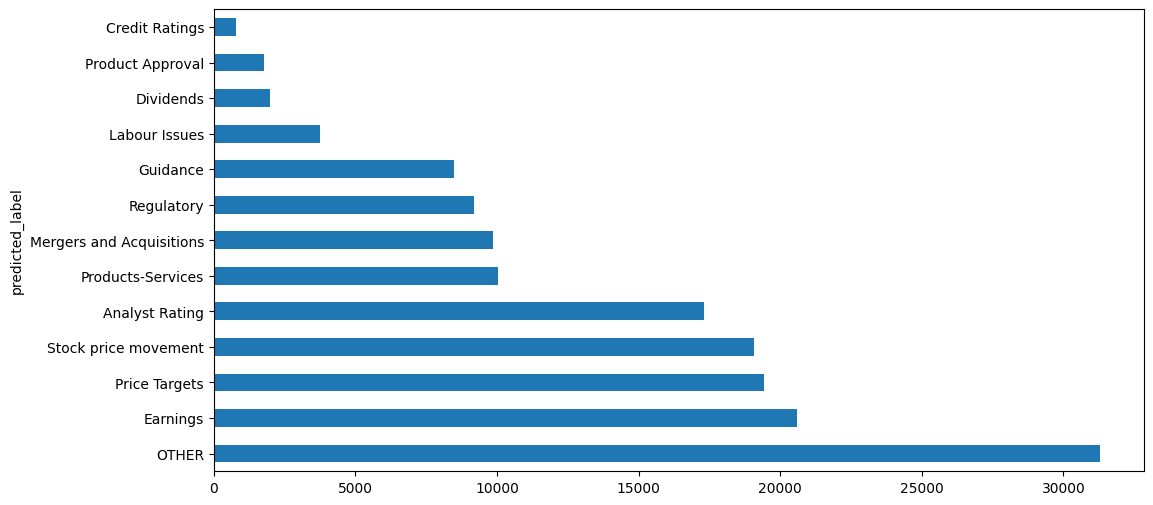

In [22]:
df_clean.groupby('predicted_label').size().sort_values(ascending=False).plot(kind='barh', figsize=(12, 6))

### 2.4 Save Results and Cleanup

Save the labeled dataset and delete the model deployment to free up resources.


In [ ]:
# Save the cleaned dataset
df_clean.to_csv('data-flywheel-fsi/data/labelled-headlines.csv', index=False)

In [23]:
delete_model_deployment("http://nemo.test","llama-3.3-70b-instruct", "meta")

Status: 200
Successfully deleted deployment meta/llama-3.3-70b-instruct


{'deleted_at': '2025-10-24 19:16:46.312716088 +0000 UTC m=+17944.971512203',
 'id': 'llama-3.3-70b-instruct',
 'message': 'Resource deleted successfully'}

In [24]:
delete_model_from_store("http://nemo.test","llama-3.3-70b-instruct", "meta")

Status: 200
Successfully deleted model meta/llama-3.3-70b-instruct from Entity Store


{'message': 'Resource deleted successfully.',
 'id': 'model-GmTMntn8B33ezC3tvWDX7j',
 'deleted_at': None}

## 3. Validation on Manually Labeled Data

Validate the teacher model's performance by comparing predictions against a manually labeled test set. This provides metrics like precision, recall, and F1-score for each category.

**⚠️ Prerequisites:** You must have the teacher model deployed (run Section 2.1 at minimum) to use this section.


In [56]:
manually_labelled_data = datasets.load_dataset('/home/shadeform/data-flywheel-fsi/data/news_data_raw/manually_labelled')
df_manually_labelled = manually_labelled_data['train'].to_pandas()

In [ ]:
df_sanity_check = await process_dataset(manually_labelled_data, concurrent=200)
df_sanity_check['predicted_label'] = df_sanity_check['predicted_label'].apply(lambda x: x.strip('[]'))

In [64]:
from sklearn.metrics import classification_report


# Print classification report
print(classification_report(df_manually_labelled['label'], df_sanity_check['predicted_label']))


                          precision    recall  f1-score   support

          Analyst Rating       0.82      0.97      0.89        96
          Credit Ratings       0.98      0.85      0.91        61
               Dividends       1.00      0.99      0.99        71
                Earnings       0.97      0.93      0.95        75
                Guidance       0.99      0.88      0.93        83
           Labour Issues       0.77      0.82      0.80        88
      Management changes       0.00      0.00      0.00        22
Mergers and Acquisitions       0.89      0.85      0.87        88
                   OTHER       0.63      0.81      0.71        93
           Price Targets       1.00      1.00      1.00        66
        Product Approval       1.00      0.82      0.90        72
       Products-Services       0.89      0.82      0.85        49
              Regulatory       0.71      0.82      0.77        85
    Stock price movement       0.76      0.79      0.77        76

        

/home/shadeform/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shadeform/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shadeform/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 4. Visualize Existing Labels

**Use this section if you skipped Section 2** to visualize the distribution of pre-existing labels in the dataset.

This section does not require model deployment and works with the pre-generated labels.


In [25]:
#use this code if you skipped the first section
label_tracker = {}
for i in data['train']['label']:
    if i not in label_tracker:
        label_tracker[i] = 0
    label_tracker[i] += 1
df_labels = pd.DataFrame(list(label_tracker.items()), columns=['label', 'count'])

In [26]:
df_labels['label'] = df_labels['label'].str.replace(r'\[\[|\]\]', '', regex=True)
df_labels = df_labels.sort_values(by='count', ascending=False)

<Axes: ylabel='label'>

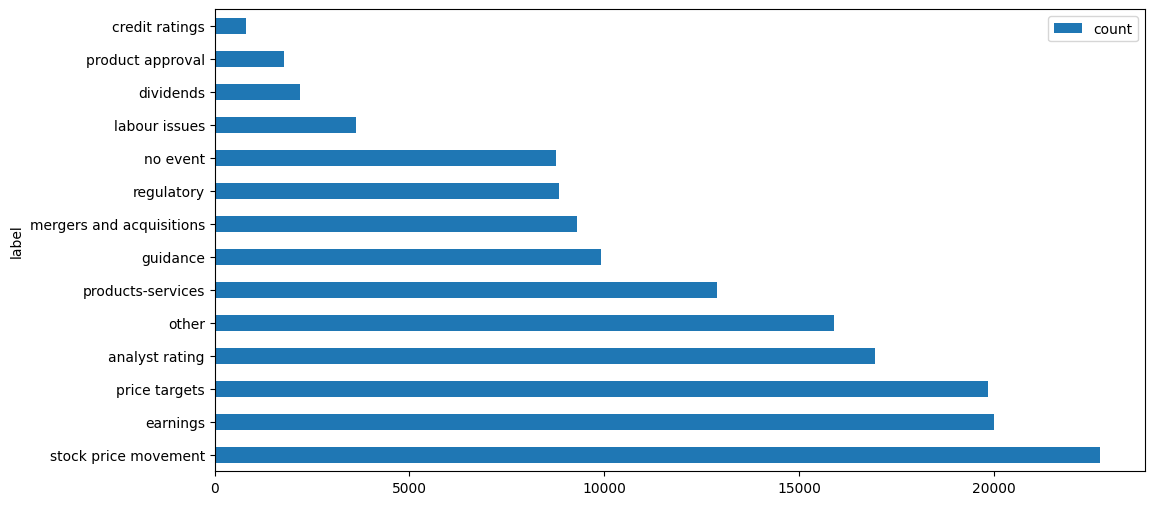

In [27]:
df_labels.plot(kind='barh', x='label', y='count', figsize=(12, 6))